In [1]:
import pandas as pd
import numpy as np

## Exploratory Data Analysis
Clean the dataset and find seasonalities

In [3]:
df = pd.read_csv('MTA_Subway_Ridership_Data_Clean.csv')
df["Date"] = pd.to_datetime(df["Date"], format="%m/%d/%Y")
df.set_index("Date", inplace=True)
df.rename(columns={
    "Subways: Total Estimated Ridership" : "Total Ridership",
    "Subways: % of Comparable Pre-Pandemic Day" : "Pre-Pandemic Ridership"
}, inplace=True)

In [4]:
df.head()

,Total Ridership,Pre-Pandemic Ridership
Date,,
2020-03-01,2212965,0.97
2020-03-02,5329915,0.96
2020-03-03,5481103,0.98
2020-03-04,5498809,0.99
2020-03-05,5496453,0.99


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

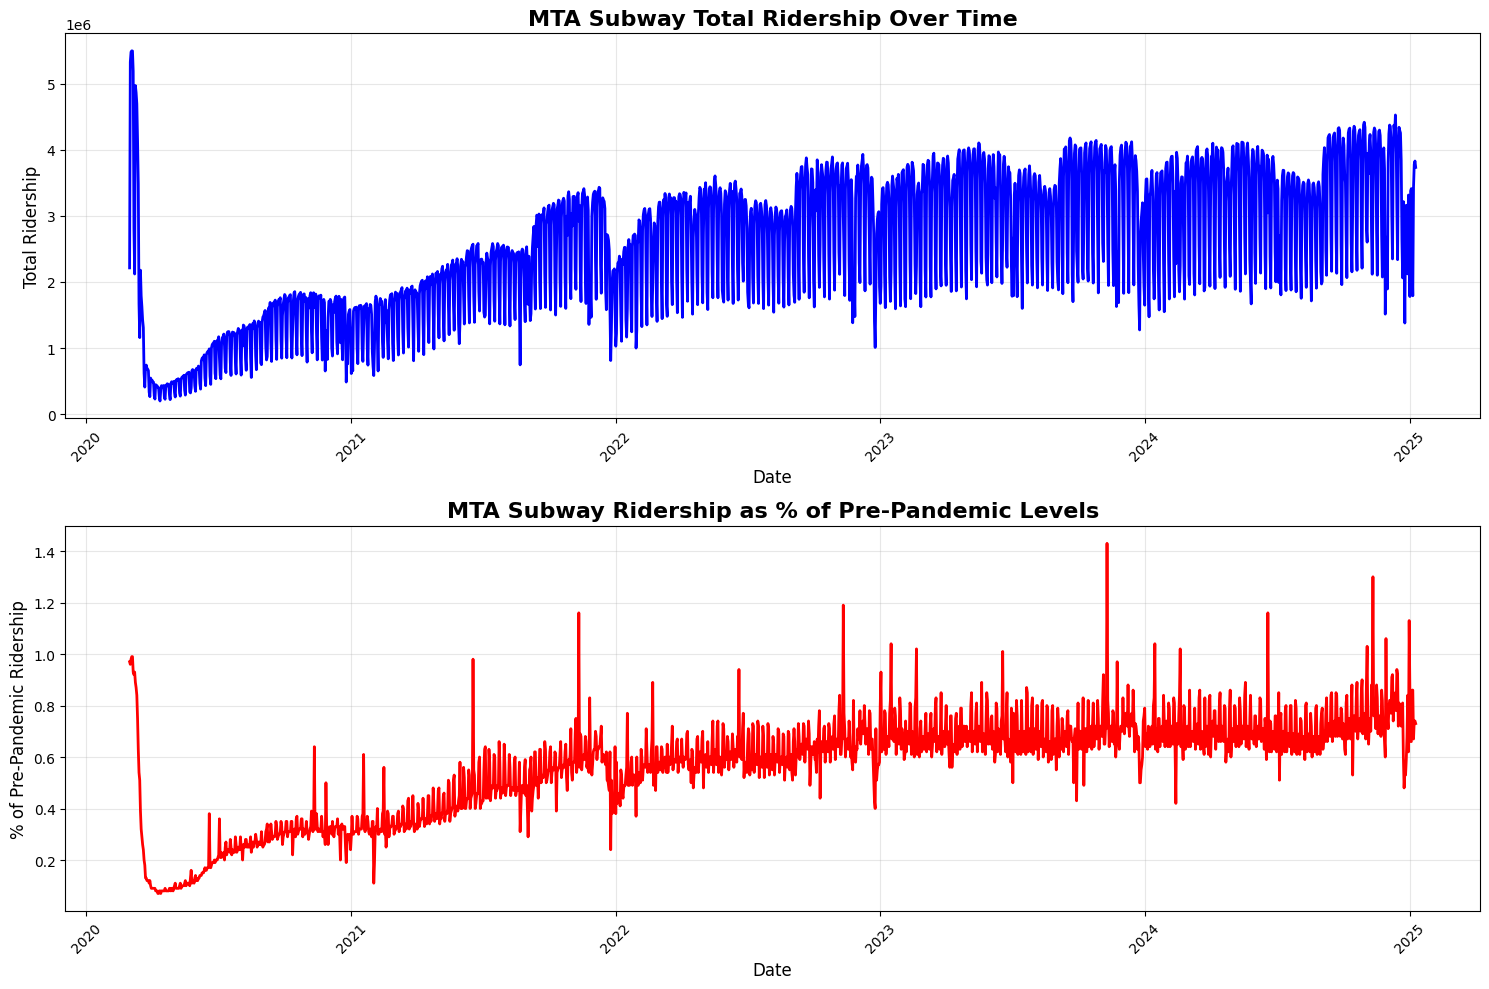

In [7]:
# Plot the ridership data
plt.figure(figsize=(15, 10))

# Plot 1: Total Ridership over time
plt.subplot(2, 1, 1)
plt.plot(df.index, df['Total Ridership'], linewidth=2, color='blue')
plt.title('MTA Subway Total Ridership Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Ridership', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Plot 2: Pre-Pandemic Ridership percentage over time
plt.subplot(2, 1, 2)
plt.plot(df.index, df['Pre-Pandemic Ridership'], linewidth=2, color='red')
plt.title('MTA Subway Ridership as % of Pre-Pandemic Levels', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('% of Pre-Pandemic Ridership', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


From the plots above, we can see that there are yearly seasonalities, in addition to weekly seasonalities. Also, the year `2020` is an outlier because of the COVID pandemic. We will now see if the Box-Cox transform is needed

In [8]:
from scipy.stats import boxcox

_, LAMBDA = boxcox(df['Total Ridership'].values)
print(f"Estimated LAMBDA: {LAMBDA}")

Estimated LAMBDA: 0.9725707831410361


We see $\lambda \approx 0.9726$ which is very close to $1$, so the transform is not needed.

In [10]:
from scipy.optimize import minimize
from numpy.linalg import lstsq

In [13]:
def buildFreqs(periods, Ks):
    frequencies = []
    for m, k in zip(periods, Ks):
        for j in range(1, k+1):
            frequencies.append(2.0 * np.pi * j / m)
    return np.array(frequencies)

In [12]:
def OLSInit(Y, frequencies):
    N = len(Y)
    T = np.arange(N)
    X = np.column_stack([np.ones(N), T])
    if frequencies.size > 0:
        cos_cols = [np.cos(freq * T) for freq in frequencies]
        sin_cols = [np.sin(freq * T) for freq in frequencies]
        X = np.column_stack([X] + cos_cols + sin_cols)
    coeff, *_ = lstsq(X, Y, rcond=None)
    intercept, slope = coeff[0], coeff[1]
    H = len(frequencies)
    if H > 0:
        a0, b0 = coeff[2:2+H], coeff[2+H:2+2*H]
    else:
        a0, b0 = np.zeros(0), np.zeros(0)
    return intercept, slope, a0, b0


In [14]:
Seasonalities = [7, 365.25]
Ks = [3, 3]
freqs = buildFreqs(Seasonalities, Ks)

In [18]:
intercept, slope, a0, b0 = OLSInit(df['Total Ridership'].values.astype(float), freqs)
print(f"Intercept: {intercept}\nSlope: {slope}\na0: {a0}\nb0: {b0}")

Intercept: 1287887.3186599067
Slope: 1411.7872347554087
a0: [-665306.17099161 -277747.62900503  -87864.58684721   -3999.06495396
   36738.73428908  150349.25224027]
b0: [207362.41197827 176524.76575347  71129.49786887 -50482.49455461
 158149.4638902  -20310.69305063]


We can fit the **OLS** (Ordinary Least Squares) curve to our data

In [19]:
def fitOLS(y, freqs, intercept, slope, a0, b0):
    N = len(y)
    T = np.arange(N)
    fit = intercept + slope * T
    if freqs.size > 0:
        for j, lmbda in enumerate(freqs):
            fit += a0[j] * np.cos(lmbda * T) + b0[j] * np.sin(lmbda * T)
    return fit

Text(0, 0.5, 'Total Ridership')

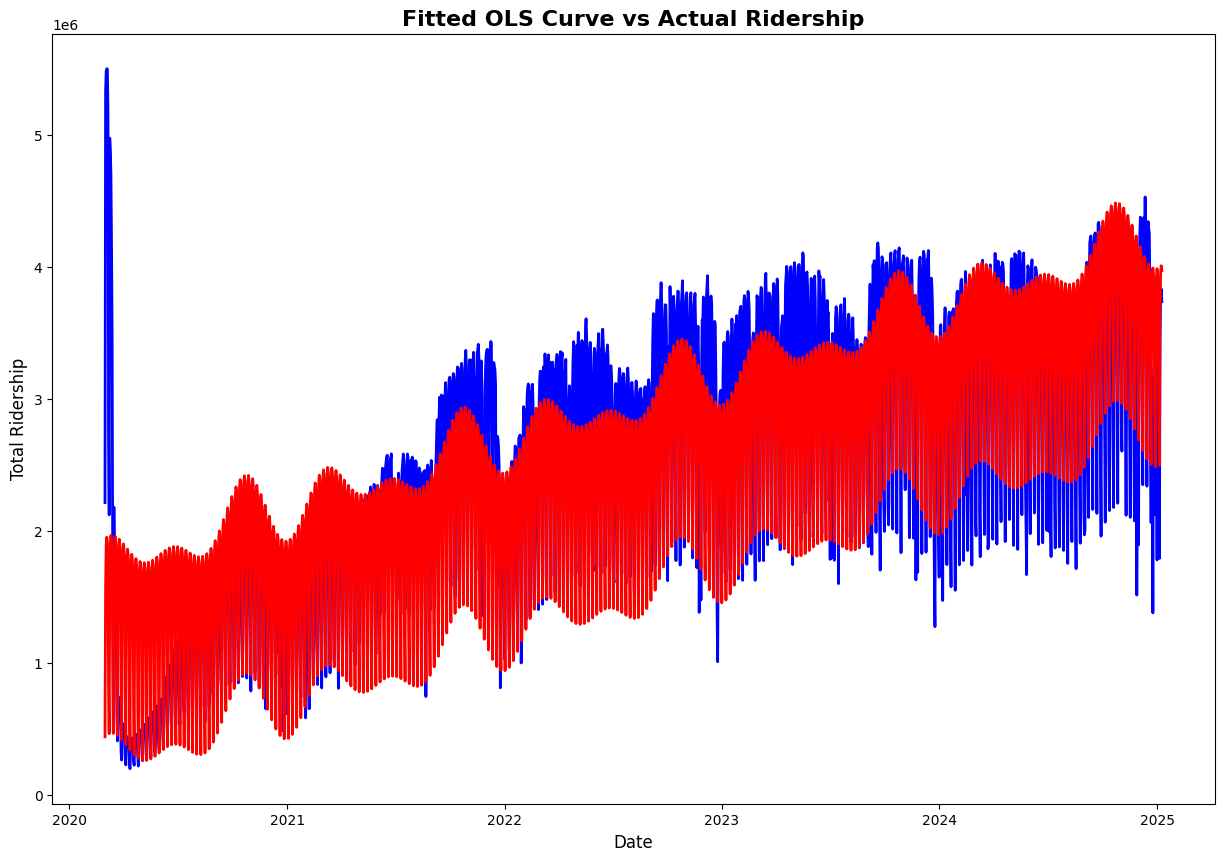

In [20]:
fittedVals = fitOLS(df['Total Ridership'].values, freqs, intercept, slope, a0, b0)
plt.figure(figsize=(15, 10))
plt.plot(df.index, df['Total Ridership'], linewidth=2, color='blue', label='Actual Ridership')
plt.plot(df.index, fittedVals, linewidth=2, color='red', label='Fitted OLS Curve')
plt.title('Fitted OLS Curve vs Actual Ridership', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Ridership', fontsize=12)

We can see that the **OLS** curve does a pretty good job of fitting the ridership data, with the exception of the peak before the drop in ridership due to the COVID pandemic.